In [1]:
from torch import nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import pyro.distributions as dist
import pyro
import pyro.optim
from pyro.infer import SVI, Trace_ELBO
torch.cuda.is_available()
from pyro.contrib import autoguide
import seaborn as sns

# Standard neural network

In [8]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device='cpu'):
        super(Model, self).__init__()
        self.out = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.out(x)
    

In [3]:
class Reshape:
    def __init__(self, new_size):
        self.new_size = new_size
    
    def __call__(self, x):
        return x.view(self.new_size)

batch_size = 128
transformation = transforms.Compose([
                      transforms.ToTensor(),
                      Reshape((-1, 28*28))
                  ])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist-data/', train=True, download=True,
                  transform=transformation),
    batch_size=batch_size,
    shuffle=True
)


test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, 
                       transform=transformation
                       ),
        batch_size=batch_size, 
        shuffle=True)

Processing...
Done!


In [ ]:
criterion = nn.CrossEntropyLoss()
def train(m, epochs=5, device='cpu'):
    
    optim = torch.optim.Adam(m.parameters(), lr=0.05)
    for e in range(epochs):
        c = 0
        for x, y in train_loader:
            c += 1
            if device == 'cuda':
                x = x.cuda()
                y = y.cuda()
            y_pred = m(x)
            loss = criterion(y_pred, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            if (c + 1) % (50) == 0:
                print("[iteration %04d] loss: %.4f  images seen: %d" % (c + 1, loss.item(), c * batch_size))
            
        print('Epoch:', e + 1)
            
m = Model(28* 28, 1024, 10, 'cuda')
train(m, device='cuda')

# Bayesian Neural Network

In [9]:
pyro.clear_param_store()

def create_unit_priors(params):
    return dist.Normal(loc=torch.zeros_like(params),
                    scale=torch.ones_like(params))

def create_guide_priors(name, params):
    return dist.Normal(
        loc=pyro.param(name + '_mu', torch.randn_like(params)),
        scale=F.softplus(pyro.param(name + '_sigma', torch.randn_like(params)))
    )


class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device='cpu'):
        super(Model, self).__init__()
        self.output_size = output_size
        self.input = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        if device == 'cuda':
            self.cuda()
    
    def forward(self, x):
        x = self.input(x)
        x = self.out(F.relu(x))
        return x.view(-1, self.output_size)
    
    # IMPORTANT LIFTED MODULE DOES NOT WORK WITH nn.Sequential. Need to name the priors perfectly
    def model(self, x, y):
        # priors
        priors = {
            "input.weight": create_unit_priors(self.input.weight),
            "input.bias": create_unit_priors(self.input.bias),
            "out.weight": create_unit_priors(self.out.weight),
            "out.bias": create_unit_priors(self.out.bias),
        }
         # lift model parameters to random variables sampled from the priors
        lifted_model = pyro.random_module('module', self, priors)

        sampled_m = lifted_model().cuda()

        lhat = sampled_m(x)
        pyro.sample('obs', dist.Categorical(logits=lhat), obs=y)
    
    def guide(self, x, y):
        priors = {
            "input.weight": create_guide_priors('layer_1_w', self.input.weight),
            "input.bias": create_guide_priors('layer_1_b', self.input.bias),
            "out.weight": create_guide_priors('layer_out_w', self.out.weight).independent(1), # why independent?
            "out.bias": create_guide_priors('layer_out_b', self.out.bias)
        }
        lifted_model = pyro.random_module('module', self, priors)

        return lifted_model().cuda()


    
m = Model(28* 28, 1024, 10, 'cuda')

In [10]:
optim = pyro.optim.Adam({"lr": 0.01})
svi = SVI(m.model, m.guide, optim, loss=Trace_ELBO())

In [11]:
epochs = 5
loss = 0

for e in range(epochs):
    c = 0
    for x, y in train_loader:
        c += 1
        x = x.cuda()
        y = y.cuda()
        loss = svi.step(x, y)
        if (c + 1) % (50) == 0:
            print("[iteration %04d] loss: %.4f  images seen: %d" % (c + 1, loss, c * batch_size))
    print('Epoch:', e + 1)

[iteration 0050] loss: 560400.0939  images seen: 6272
[iteration 0100] loss: 404071.2365  images seen: 12672
[iteration 0150] loss: 301482.9164  images seen: 19072
[iteration 0200] loss: 237980.7431  images seen: 25472
[iteration 0250] loss: 192912.4793  images seen: 31872
[iteration 0300] loss: 154851.5447  images seen: 38272
[iteration 0350] loss: 126995.5412  images seen: 44672
[iteration 0400] loss: 109351.9992  images seen: 51072
[iteration 0450] loss: 92512.8703  images seen: 57472
Epoch: 1
[iteration 0050] loss: 76524.1199  images seen: 6272
[iteration 0100] loss: 65880.1059  images seen: 12672
[iteration 0150] loss: 53568.6567  images seen: 19072
[iteration 0200] loss: 48625.9135  images seen: 25472
[iteration 0250] loss: 43800.5043  images seen: 31872
[iteration 0300] loss: 38845.5785  images seen: 38272
[iteration 0350] loss: 36009.5917  images seen: 44672
[iteration 0400] loss: 32476.7465  images seen: 51072
[iteration 0450] loss: 29945.0096  images seen: 57472
Epoch: 2
[ite

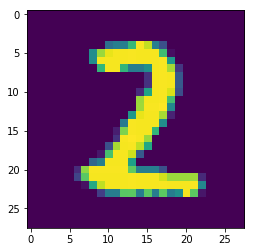

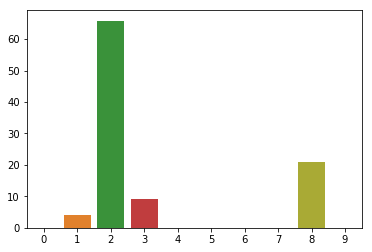

In [14]:
for x, y in test_loader:
    x = x.cuda()
    y = y.cuda()
    x = x[-1]

    with torch.no_grad():
        a = np.array([F.softmax(m.guide(1, 1)(x), -1).cpu().numpy() for _ in range(100)])[:, -1]
        
    break
    
plt.imshow(x.cpu().numpy().reshape((28, 28)))
plt.show()
sns.barplot(np.arange(10), a.sum(0))